# Lecture 16

# A Zoo of Neural Networks

## Pre-history: Hopfield Networks

In 2024 the [Nobel Prize in Physics](https://www.nobelprize.org/prizes/physics/2024/press-release/) went to Jonh Hopfield and Geoffrey Hinton "for foundational discoveries and inventions that enable machine learning with artificial neural networks." So, it is appropriate that we start the history at Hopfield networks:


![Hopfield Networks](../images/hopfield.webp)<br>
(Image source: [Hopfield Networks: Neural Memory Machines](https://towardsdatascience.com/hopfield-networks-neural-memory-machines-4c94be821073/))


The Hopfield network, introduced by John Hopfield in the early 1980s, represents one of the earliest and most mathematically tractable models of recurrent neural computation. Unlike feedforward neural networks—which are primarily designed for tasks such as function approximation or classification—Hopfield networks serve a fundamentally different purpose: they function as content-addressable memory systems. Their primary role is to retrieve entire stored patterns from corrupted or partial inputs through a dynamical process governed by an energy function. In this sense, Hopfield networks exemplify how memory and computation can be realized through the emergent behavior of a distributed dynamical system.

Formally, a Hopfield network consists of $n$ binary-valued neurons $x_1, \dotsc, x_n$, where each state variable satisfies $x_i \in {-1, +1}$. The neurons are fully and symmetrically interconnected through a weight matrix $W = (w_{ij})$, with the symmetry condition $w_{ij} = w_{ji}$ and no self-interactions, i.e., $w_{ii} = 0$. At any given time, the global state of the network is described by a vector $x = (x_1, \dotsc, x_n) \in {-1, +1}^n$.

The network evolves via an asynchronous update rule: the state of a single neuron $x_i$ is updated according to the equation

$$
x_i \mapsto \text{sgn}\left(\sum_{j=1}^n w_{ij} x_j - \theta_i\right),
$$

where $\theta_i$ is a threshold parameter (often assumed to be zero for analytical convenience), and the sign function is defined as $\text{sgn}(z) = +1$ if $z \geq 0$, and $-1$ otherwise. Although synchronous updates are also possible, they do not, in general, guarantee the monotonic descent of the energy function.

A central mathematical feature of the Hopfield model is the existence of a global Lyapunov function, or energy function, defined by

$$
E(x) = -\frac{1}{2} \sum_{i,j} w_{ij} x_i x_j + \sum_i \theta_i x_i.
$$

This energy function serves as a potential function for the dynamics: it decreases or remains constant with each asynchronous update. To see this explicitly, consider updating a single neuron $x_k$ while keeping all other components fixed. If $x_k^{\text{new}}$ denotes the updated value of $x_k$, then the change in energy is given by

$$
\Delta E = E(x_1, \dotsc, x_k^{\text{new}}, \dotsc, x_n) - E(x_1, \dotsc, x_k, \dotsc, x_n) = -\left(x_k^{\text{new}} - x_k\right)\left(\sum_j w_{kj} x_j - \theta_k\right).
$$

Since the update rule aligns $x_k^{\text{new}}$ with the local field $\sum_j w_{kj} x_j - \theta_k$, it follows that $\Delta E \leq 0$. Consequently, the dynamics always move the system downhill in energy, ensuring eventual convergence to a local minimum—i.e., a stable fixed point.

The network may be trained to store a finite collection of binary patterns ${x^{(1)}, \dotsc, x^{(p)}}$ via Hebbian learning. In this case, the synaptic weights are defined by the outer-product formula

$$
w_{ij} = \frac{1}{n} \sum_{\mu = 1}^p x_i^{(\mu)} x_j^{(\mu)}.
$$

This encoding ensures that each pattern $x^{(\mu)}$ becomes, approximately, a fixed point of the network dynamics. However, the storage capacity of the network is limited: beyond a certain number of stored patterns, interference effects—referred to as *crosstalk*—degrade retrieval accuracy. Analytical results derived from statistical mechanics (Amit, Gutfreund, and Sompolinsky, 1985) demonstrate that reliable retrieval is possible as long as the number of stored patterns $p$ satisfies $p \lesssim 0.138 n$. This threshold corresponds to the phase transition between the *memory phase* and the *spin-glass phase* of the energy landscape.

The Hopfield model is deeply connected to the theory of spin glasses: the binary neurons play the role of Ising spins, and the weights $w_{ij}$ model pairwise couplings. The resulting energy landscape is highly non-convex, and although it supports useful attractors corresponding to stored memories, it may also contain numerous spurious local minima that do not correspond to any stored pattern.

Despite these limitations, the Hopfield network remains a paradigmatic example of memory retrieval via emergent collective behavior. Once a pattern has been stored, the network is capable of retrieving it from a corrupted version through iterative correction. More precisely, if $x^{(\mu)}$ is a stored pattern and $x(0)$ is a noisy input sufficiently close to $x^{(\mu)}$ in Hamming distance, then the deterministic evolution

$$
x(0) \mapsto x(1) \mapsto x(2) \mapsto \dotsb \mapsto x^*
$$

will typically converge to $x^\* = x^{(\mu)}$. This convergence reflects the network’s capacity to act as an **error-correcting memory**, stabilizing in the clean pattern and remaining there under further updates. In this sense, the Hopfield network “recognizes” the noisy input as a corrupted version of a known pattern and “repeats” it by converging to its exact form.

Nonetheless, when the number of stored patterns exceeds the capacity bound, retrieval may fail. Spurious attractors—fixed points not associated with any stored pattern—may emerge, and some basins of attraction may shrink, making the network sensitive to the magnitude of the noise in the input.

Within its operational regime, the Hopfield network exemplifies robust, distributed, and decentralized pattern recognition through dynamical attractor behavior. It laid the groundwork for modern **energy-based models** such as Boltzmann machines, and remains an instructive theoretical model for understanding memory, stability, and convergence in recurrent neural systems.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import load_wine, load_digits, fetch_olivetti_faces, load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, classification_report

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
# Define Hopfield network class
class HopfieldNet:
    def __init__(self, n_units):
        self.n = n_units
        self.W = torch.zeros((n_units, n_units))

    def train_hebbian(self, patterns):
        """Train using Hebbian learning rule"""
        self.W.zero_()
        for p in patterns:
            self.W += torch.outer(p, p)
        self.W.fill_diagonal_(0)  # No self-connections
        self.W /= self.n

    def energy(self, state):
        """Compute energy of a given network state"""
        return -0.5 * torch.dot(state, self.W @ state)

    def run_async_dynamics(self, state, max_steps=100):
        """Run asynchronous update until convergence or max_steps"""
        state = state.clone()
        for step in range(max_steps):
            i = torch.randint(0, self.n, (1,)).item()
            net_input = torch.dot(self.W[i], state)
            new_val = torch.sign(net_input)
            if new_val == 0:  # Handle zero input
                new_val = state[i]
            if new_val != state[i]:
                state[i] = new_val
        return state

In [3]:
# Generate binary patterns (+1/-1 vectors)
def generate_patterns(n_patterns, n_units):
    patterns = []
    for _ in range(n_patterns):
        p = torch.randint(0, 2, (n_units,)).float()
        p[p == 0] = -1
        patterns.append(p)
    return patterns

# Add noise by flipping k bits
def add_noise(pattern, k):
    noisy = pattern.clone()
    flip_indices = torch.randperm(len(pattern))[:k]
    noisy[flip_indices] *= -1
    return noisy

In [6]:
# Parameters
n_units = 10
n_patterns = 3

# Create and train Hopfield network
hopfield = HopfieldNet(n_units)
patterns = generate_patterns(n_patterns, n_units)
hopfield.train_hebbian(patterns)

# Choose a pattern, add noise, and run dynamics
index = 1  # Choose one of the stored patterns
original = patterns[index]
noisy = add_noise(original, k=3)
retrieved = hopfield.run_async_dynamics(noisy)

print("Original Pattern: ", original.tolist())
print("Noisy Input     : ", noisy.tolist())
print("Retrieved Pattern:", retrieved.tolist())

Original Pattern:  [-1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0]
Noisy Input     :  [-1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0]
Retrieved Pattern: [-1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0]


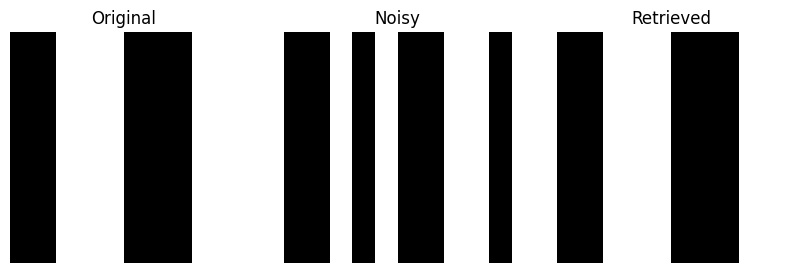

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for ax, vec, title in zip(axes, [original, noisy, retrieved], ["Original", "Noisy", "Retrieved"]):
    ax.imshow(vec.view(1, -1), cmap="gray", aspect="auto")
    ax.set_title(title)
    ax.axis("off")
plt.show()

## Ordinary Feed Forward Networks with Numerical Output

We now start our study of ordinary neural networks, starting with the classical feedforward architecture designed to approximate functions from Euclidean space to Euclidean space. The focus of this initial exposition will be on multilayer perceptrons (MLPs), which are a subclass of artificial neural networks composed of several layers of linear transformations followed by nonlinear activation functions.

Let us consider a neural network as a function

$$
f: \mathbb{R}^d \longrightarrow \mathbb{R}^k,
$$

constructed via a composition of affine maps and nonlinearities. Here, $\mathbb{R}^d$ is the input space, typically representing feature vectors of dimension $d$, and $\mathbb{R}^k$ is the output space, which might represent regression targets or classification logits depending on the context.

A feedforward neural network with $L$ hidden layers is defined recursively as follows. Let $x^{(0)} = x \in \mathbb{R}^d$ be the input vector. For each layer $\ell = 1, \dotsc, L$, we define

$$
x^{(\ell)} = \phi^{(\ell)}\left(W^{(\ell)} x^{(\ell-1)} + b^{(\ell)}\right),
$$

where $W^{(\ell)} \in \mathbb{R}^{n_{\ell} \times n_{\ell-1}}$ is the weight matrix for layer $\ell$, $b^{(\ell)} \in \mathbb{R}^{n_\ell}$ is the corresponding bias vector, and $\phi^{(\ell)}$ is a nonlinear activation function applied coordinate-wise. The sequence of dimensions satisfies $n_0 = d$, and $n_L$ is typically either equal to $k$ or followed by a final linear layer mapping to $\mathbb{R}^k$.

The final output of the network is given by

$$
f(x) = W^{(L+1)} x^{(L)} + b^{(L+1)} \in \mathbb{R}^k,
$$

when no activation is used in the output layer, as is standard in regression tasks. Alternatively, in classification problems, a further nonlinearity such as the softmax function may be applied to interpret the outputs as probabilities.

The activation functions $\phi^{(\ell)}$ introduce nonlinearity and are crucial in enabling the network to approximate a broad class of functions. Common choices include the rectified linear unit (ReLU), defined as $\phi(z) = \max{0, z}$, the sigmoid function $\sigma(z) = \frac{1}{1 + e^{-z}}$, and the hyperbolic tangent $\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$. The ReLU function has become the standard due to its computational simplicity and favorable gradient properties in high-dimensional optimization.

The entire collection of parameters

$$
\Theta = \left\{(W^{(\ell)}, b^{(\ell)}) : 1 \leq \ell \leq L+1\right\}
$$

constitutes the degrees of freedom of the network. Given a training set ${(x_i, y_i)}_{i=1}^N \subset \mathbb{R}^d \times \mathbb{R}^k$, learning consists in finding values for $\Theta$ such that the outputs $f(x_i)$ approximate the targets $y_i$ in a manner minimizing a predefined loss function. A typical choice is the squared error loss

$$
\mathcal{L}(\Theta) = \frac{1}{N} \sum_{i=1}^N \left\|f(x_i) - y_i\right\|^2,
$$

in regression, or the cross-entropy loss in classification.

Training is performed via gradient-based optimization, most commonly stochastic gradient descent (SGD) or its variants (e.g., Adam, RMSprop), using the backpropagation algorithm to efficiently compute gradients of the loss function with respect to the parameters of the network. Backpropagation is a recursive application of the chain rule, systematically computing derivatives layer by layer from the output to the input (hence the name “back”-propagation).

The universal approximation theorem asserts that such feedforward networks with at least one hidden layer and sufficiently many neurons can approximate any continuous function on a compact subset of $\mathbb{R}^d$ arbitrarily well, under mild conditions on the activation function (e.g., nonpolynomial, continuous). However, practical considerations such as generalization, overfitting, and training efficiency typically require multiple hidden layers, leading to what is now known as *deep learning*.

## Loss Functions

When neural networks are used for problems involving **numerical outputs**, such as regression tasks or function approximation, the loss functions must be designed to quantify the discrepancy between real-valued predicted outputs and real-valued target values. In this context, loss functions are typically defined over $\mathbb{R}^k \times \mathbb{R}^k$, where both the prediction $f$\theta(x)$ and the target $y$ are elements of $\mathbb{R}^k$.

The choice of loss function should reflect both the **statistical properties of the noise** (e.g., Gaussian vs. heavy-tailed), and the **objective of the task** (mean prediction vs. quantiles or medians). In neural network training, MSE is often the default due to its simplicity and strong theoretical foundation, but alternatives like Huber and log-cosh offer practical improvements when dealing with non-Gaussian error structures or heavy-tailed data distributions.


We now provide a formal and conceptual overview of the most common loss functions in this setting, together with a critical analysis of their respective mathematical properties.

### 1. Mean Squared Error (MSE)

The **mean squared error**, also known as the $L^2$ loss, is defined by

$$
\mathcal{L}_{\text{MSE}}(\theta) = \frac{1}{N} \sum_{i=1}^N \left\| f_\theta(x_i) - y_i \right\|_2^2.
$$

This loss penalizes the **squared Euclidean distance** between the predicted and true values.

**Pros**:

* Smooth and differentiable; gradients are easy to compute.
* Strongly convex for linear models, leading to unique minima.
* Statistically optimal under the assumption that errors $\varepsilon_i = f(x_i) - y_i$ are i.i.d. Gaussian.

**Cons**:

* Sensitive to outliers due to the quadratic penalty: large deviations are disproportionately penalized.
* Encourages models to approximate the **conditional mean** of the output distribution.

### 2. Mean Absolute Error (MAE)

The **mean absolute error**, or $L^1$ loss, is given by

$$
\mathcal{L}_{\text{MAE}}(\theta) = \frac{1}{N} \sum_{i=1}^N \left\| f_\theta(x_i) - y_i \right\|_1 = \frac{1}{N} \sum_{i=1}^N \sum_{j=1}^k \left| f_\theta(x_i)_j - y_{i,j} \right|.
$$

This loss penalizes linearly in the absolute difference between predicted and true values.

**Pros**:

* More robust to outliers compared to MSE.
* Encourages approximation of the **conditional median** of the output distribution.

**Cons**:

* Not differentiable at zero; may lead to subgradient-based optimization.
* Gradients are constant in magnitude, which can slow convergence near the optimum.

### 3. Huber Loss

The **Huber loss** interpolates between MSE and MAE, defined by

$$
\mathcal{L}_\delta(r) =
\begin{cases}
\frac{1}{2} r^2 & \text{if } |r| \leq \delta, \\
\delta (|r| - \frac{1}{2} \delta) & \text{if } |r| > \delta,
\end{cases}
$$

where $r = f_\theta(x_i) - y_i$ is the residual, and $\delta > 0$ is a tunable threshold.

**Pros**:

* Quadratic near zero (like MSE) and linear in the tails (like MAE).
* Robust to outliers while retaining differentiability everywhere.
* Provides a compromise between variance and robustness.

**Cons**:

* Requires selection of a hyperparameter $\delta$.
* More complex to implement than MSE or MAE.

### 4. Quantile Loss

The **quantile loss** is used to estimate conditional quantiles. For a quantile level $\tau \in (0,1)$, the loss is defined as

$$
\mathcal{L}_\tau(r) = 
\begin{cases}
\tau r & \text{if } r \geq 0, \\
(\tau - 1) r & \text{if } r < 0,
\end{cases}
$$

where again $r = f_\theta(x_i) - y_i$.

**Pros**:

* Allows modeling of **conditional quantiles** rather than just central tendencies.
* Useful in heteroskedastic regression and probabilistic forecasting.

**Cons**:

* Non-differentiable at zero.
* Requires explicit choice of quantile level $\tau$.


### 5. Log-Cosh Loss

Defined by

$$
\mathcal{L}_{\text{log-cosh}}(r) = \log \left( \cosh(r) \right),
$$

this loss behaves like $r^2/2$ near $r = 0$ and like $|r| - \log 2$ for large $|r|$.

**Pros**:

* Smooth approximation to MAE.
* Less sensitive to outliers than MSE.
* Fully differentiable with well-behaved gradients.

**Cons**:

* Less interpretable than MSE or MAE.
* Slightly more expensive computationally due to non-polynomial activation.


### Comparative Summary

| Loss Function | Optimal Estimate     | Robustness to Outliers | Differentiability | Use Case                                  |
| ------------- | -------------------- | ---------------------- | ----------------- | ----------------------------------------- |
| MSE           | Conditional mean     | Low                    | Smooth everywhere | General regression (Gaussian noise)       |
| MAE           | Conditional median   | High                   | Not at 0          | Outlier-resistant regression              |
| Huber         | Smooth blend         | Moderate               | Smooth everywhere | Tradeoff between MSE and MAE              |
| Quantile      | Conditional quantile | High                   | Not at 0          | Probabilistic modeling of asymmetry       |
| Log-Cosh      | Smooth approx.       | Moderate               | Smooth everywhere | Robust, stable training with clean curves |



## A Computational Example

Below, you'll find a simple feedforward neural network for predicting a numerical response variable:

Let us load UCI Wine dataset:

In [8]:
wine_data = load_wine()
X = wine_data['data']
y = wine_data['target']

# Extract the feature to predict: Nonflavanoid_phenols is index 7
target = X[:, 7]
features = np.delete(X, 7, axis=1)

# Standardize features
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(features)
y_scaled = scaler_y.fit_transform(target.reshape(-1, 1)).flatten()

Let us do a train-test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

Let us define neural network with one hidden layer

In [10]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Net, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.activation(self.hidden(x))
        return self.output(x)

Here we instantiate the model, and set the loss function, and finally declare which optimizer we are going to use:

In [11]:
input_dim = X_train.shape[1]
hidden_dim = 10
model = Net(input_dim, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Rprop(model.parameters(), lr=0.01) # Add momentum to the optimizer
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95) # Gradually decaying learning rate

Let us do the training loop. We set the number of epochs as 500:

In [12]:
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 1.1331
Epoch 50, Loss: 0.2245
Epoch 100, Loss: 0.1549
Epoch 150, Loss: 0.1433
Epoch 200, Loss: 0.1304
Epoch 250, Loss: 0.1162
Epoch 300, Loss: 0.1105
Epoch 350, Loss: 0.1052
Epoch 400, Loss: 0.1026
Epoch 450, Loss: 0.1013


And finally, let us evaluate the quality of our model on the test dataset.

In [13]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    mse = mean_squared_error(y_test_tensor.numpy(), predictions.numpy())
    print(f"Test MSE (in scaled units): {mse:.4f}")
    # Inverse transform to original scale
    predictions_original = scaler_y.inverse_transform(predictions.numpy().reshape(-1, 1))
    y_test_original = scaler_y.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))
    mse_original = mean_squared_error(y_test_original, predictions_original)
    print(f"Test MSE (in original units): {mse_original:.4f}")

Test MSE (in scaled units): 0.6533
Test MSE (in original units): 0.0101


## Ordinary Neural Network with Discrete Outputs

We now turn our attention to the use of neural networks for **supervised classification tasks**, where the goal is to assign input vectors to discrete categories based on labeled training data. This setting assumes the availability of a finite dataset ${(x_i, y_i)}_{i=1}^N$ where each $x_i \in \mathbb{R}^d$ is an input vector, and each $y_i$ is a categorical label drawn from a finite set ${1, 2, \dotsc, K}$ corresponding to $K$ distinct classes.

In this context, a neural network serves as a parametric function $f_\theta: \mathbb{R}^d \to \mathbb{R}^K$, where the output $f_\theta(x)$ is interpreted as a score vector assigning a real-valued compatibility score to each class. The parameters $\theta$ encode the weights and biases of the network, and learning consists in adjusting $\theta$ to minimize a loss function that quantifies prediction error on the training set.

The architecture we consider is a **multilayer feedforward network**, also known as a **multilayer perceptron (MLP)**. This network maps the input $x$ through a sequence of hidden layers:

$$
\begin{aligned}
h^{(1)} &= \phi^{(1)}(W^{(1)} x + b^{(1)}), \\
h^{(2)} &= \phi^{(2)}(W^{(2)} h^{(1)} + b^{(2)}), \\
&\vdots \\
h^{(L)} &= \phi^{(L)}(W^{(L)} h^{(L-1)} + b^{(L)}), \\
f_\theta(x) &= W^{(L+1)} h^{(L)} + b^{(L+1)},
\end{aligned}
$$

where $\phi^{(\ell)}$ are nonlinear activation functions, typically chosen to be rectified linear units (ReLU), defined by $\phi(z) = \max{0, z}$ applied elementwise. The final layer is linear, and the output vector $f_\theta(x) \in \mathbb{R}^K$ is interpreted as unnormalized log-probabilities of the $K$ classes.

To convert these scores into proper probabilities, we apply the **softmax function**:

$$
\mathrm{softmax}(f_\theta(x))_k = \frac{e^{f_\theta(x)_k}}{\sum_{j=1}^K e^{f_\theta(x)_j}}, \quad \text{for } k = 1, \dotsc, K.
$$

The softmax function ensures that the output vector lies in the $K$-dimensional probability simplex, i.e., all entries are non-negative and sum to $1$. The predicted class is then the one with the highest probability.

To train the network, we minimize the **cross-entropy loss** between the true label and the predicted distribution:

$$
\mathcal{L}(\theta) = -\frac{1}{N} \sum_{i=1}^N \log \left( \mathrm{softmax}(f_\theta(x_i))_{y_i} \right),
$$

where $y_i \in {1, \dotsc, K}$ is the true class label for input $x_i$, and $\mathrm{softmax}(f_\theta(x_i))_{y_i}$ is the predicted probability assigned to that label. This loss function arises naturally from the **maximum likelihood principle** under the assumption that labels are drawn from a categorical distribution conditioned on the inputs.

The optimization of $\mathcal{L}(\theta)$ is carried out using gradient-based methods. Thanks to the chain rule, the gradient of the loss with respect to any parameter in the network can be computed efficiently using **backpropagation**, which traverses the computation graph in reverse order, storing and reusing intermediate derivatives.

From a statistical perspective, the softmax output can be interpreted as an estimator of the conditional class probability distribution $P(Y \mid X = x)$. The cross-entropy loss then corresponds to the expected negative log-likelihood:

$$
\mathbb{E}_{(X,Y) \sim \mathcal{D}}[-\log P_\theta(Y \mid X)],
$$

which is minimized when $P_\theta(Y \mid X)$ matches the true conditional distribution.

From a geometric perspective, the decision boundary between two classes $k$ and $l$ is defined as the set of inputs $x \in \mathbb{R}^d$ for which $f_\theta(x)*k = f*\theta(x)*l$. Since $f*\theta$ is a composition of affine and nonlinear transformations, the resulting decision boundaries are highly flexible and can approximate complex nonlinear manifolds.

The universal approximation theorem ensures that with enough hidden units and appropriate activation functions, such a network can approximate any measurable function (and hence any Bayes-optimal classifier) arbitrarily well on compact subsets of $\mathbb{R}^d$. However, in practice, issues such as overfitting, optimization difficulty, and generalization behavior must be addressed through techniques such as regularization, batch normalization, dropout, and early stopping.

## Loss Functions in the Context of Classification Problems

In the context of supervised classification problems, the choice of **loss function** plays a critical role in training neural networks. The loss function formalizes the objective by quantifying the discrepancy between the predicted output of the model and the true class label provided in the training data. It serves as a surrogate for the ideal (but typically non-differentiable) misclassification rate, and its properties directly influence the learning dynamics and generalization performance of the model.

Let us assume a classification task with input vectors $x \in \mathbb{R}^d$ and corresponding labels $y \in {1, 2, \dotsc, K}$, where $K$ denotes the number of classes.

### 1. Cross-Entropy Loss (a.k.a. Log Loss)

The most commonly used loss function in multiclass classification with neural networks is the **categorical cross-entropy loss**, defined by

$$
\mathcal{L}_{\text{CE}}(\theta) = - \frac{1}{N} \sum_{i=1}^N \log \left( \mathrm{softmax}(f_\theta(x_i))_{y_i} \right),
$$

where $f_\theta(x_i) \in \mathbb{R}^K$ is the output vector of the neural network, and 

$$
\mathrm{softmax}(f_\theta(x_i))_k = \frac{e^{f_\theta(x_i)_k}}{\sum_{j=1}^K e^{f_\theta(x_i)_j}}
$$ 

gives the predicted class probabilities. This loss is derived from the **log-likelihood** of a categorical distribution and is minimized when the predicted distribution exactly matches the true class distribution. The cross-entropy loss is strictly convex when composed with the softmax function, and its gradients are well-behaved in practice, making it highly suitable for gradient-based optimization.

**Statistical Interpretation**: It corresponds to the negative log-likelihood of a multinomial logistic regression model and is thus consistent with the maximum likelihood estimation framework.


### 2. Binary Cross-Entropy (BCE)

In the special case of **binary classification** ($K=2$), the cross-entropy loss simplifies to

$$
\mathcal{L}_{\text{BCE}}(\theta) = - \frac{1}{N} \sum_{i=1}^N \left[ y_i \log \sigma(f_\theta(x_i)) + (1 - y_i) \log (1 - \sigma(f_\theta(x_i))) \right],
$$

where $\sigma(z) = \frac{1}{1 + e^{-z}}$ is the sigmoid function. Here, $f_\theta(x_i) \in \mathbb{R}$ is a scalar score, and $\sigma(f_\theta(x_i)) \in (0,1)$ represents the predicted probability that $y_i = 1$.

This loss is again equivalent to the log-likelihood under a Bernoulli distribution, and minimizes the Kullback–Leibler divergence between the true and predicted label distributions.


### 3. Hinge Loss

The **hinge loss** is defined for binary classification tasks with labels $y_i \in {-1, +1}$ as

$$
\mathcal{L}_{\text{hinge}}(\theta) = \frac{1}{N} \sum_{i=1}^N \max\left(0, 1 - y_i f_\theta(x_i) \right).
$$

This loss function is motivated by the geometric margin in support vector machines (SVMs), and encourages correct classification with a margin of at least one. Unlike cross-entropy, the hinge loss is not probabilistic in interpretation but margin-based, and it is non-differentiable at the hinge point. Its subgradient can be used for optimization.

**Limitations**: While hinge loss has appealing theoretical properties in the context of large-margin classification, it is less commonly used with neural networks, primarily due to its non-smoothness and incompatibility with probabilistic outputs.

### 4. Squared Error Loss (MSE)

Although originally designed for regression tasks, the **mean squared error** (MSE) loss has been historically used in early neural networks for classification:

$$
\mathcal{L}_{\text{MSE}}(\theta) = \frac{1}{N} \sum_{i=1}^N \| f_\theta(x_i) - y_i \|^2.
$$

Here $y_i$ is often encoded as a one-hot vector in $\mathbb{R}^K$. However, MSE is not well-calibrated for classification tasks and tends to produce slower convergence and poorer probabilistic estimates compared to cross-entropy. Its gradient vanishes more slowly as the prediction approaches the correct class, which can lead to inefficient learning.

### 5. Kullback–Leibler Divergence (KL Loss)

More generally, the **KL divergence** between the true label distribution $P$ and predicted distribution $Q_\theta$ is given by

$$
D_{\mathrm{KL}}(P \| Q_\theta) = \sum_{k=1}^K P_k(x) \log \left( \frac{P_k(x)}{Q_\theta(x)_k} \right).
$$

This reduces to the cross-entropy loss when $P$ is a one-hot encoding (i.e., deterministic label), since the entropy term of $P$ is constant. The KL loss becomes particularly relevant in **label smoothing**, where $P$ is a soft label vector rather than a one-hot vector, and in **knowledge distillation**, where $P$ is the output of a teacher model.


### Summary and Comparison

| Loss Function        | Target Label Format    | Probabilistic? | Common Usage                   | Smooth? |
| -------------------- | ---------------------- | -------------- | ------------------------------ | ------- |
| Cross-Entropy        | One-hot / Integer      | Yes            | Multiclass neural networks     | Yes     |
| Binary Cross-Entropy | $0/1$ or ${-1,+1}$ | Yes            | Binary classification          | Yes     |
| Hinge Loss           | ${-1,+1}$            | No             | SVMs and margin classifiers    | No      |
| Squared Error        | One-hot                | No             | Historically used in early NNs | Yes     |
| KL Divergence        | Soft labels            | Yes            | Distillation, label smoothing  | Yes     |

In practice, **categorical cross-entropy combined with softmax** is the dominant loss function in multiclass classification with neural networks, due to its sound statistical interpretation, favorable optimization properties, and consistent performance.


We will next illustrate these ideas through a worked example, constructing and training a neural network classifier using PyTorch. Let us start by loading up our example dataset:

In [14]:
# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Reduce to binary classification: Class 0 vs Class 1
binary_filter = (y == 0) | (y == 1)
X = X[binary_filter]
y = y[binary_filter]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

Next, we define binary classification neural network.

In [15]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(BinaryClassifier, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.output = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

Next, we instantiate the model and define our loss function together with the optimizer we are going to use to do our back-propagation:

In [16]:
model = BinaryClassifier(input_dim=X.shape[1], hidden_dim=10)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

Now, let us train our model. I am using 200 epochs.

In [17]:
epochs = 200
losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(loss.item())
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.6239
Epoch 20, Loss: 0.2184
Epoch 40, Loss: 0.0617
Epoch 60, Loss: 0.0268
Epoch 80, Loss: 0.0169
Epoch 100, Loss: 0.0127
Epoch 120, Loss: 0.0103
Epoch 140, Loss: 0.0089
Epoch 160, Loss: 0.0079
Epoch 180, Loss: 0.0072


And finally we evaluate our model:

In [18]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    predicted_labels = (y_pred_test >= 0.5).float()

# Convert tensors to numpy arrays for sklearn
y_test_np = y_test_tensor.numpy().flatten()
y_pred_np = predicted_labels.numpy().flatten()

# Print full classification report
print(classification_report(y_test_np, y_pred_np, target_names=["Setosa", "Versicolor"]))

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        12
  Versicolor       1.00      1.00      1.00         8

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



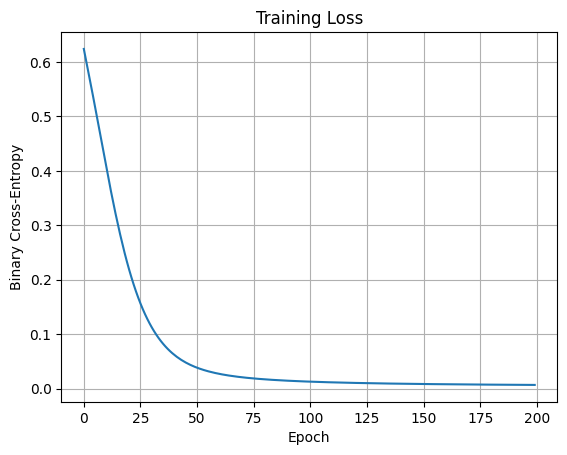

In [19]:
# Plot training loss
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy")
plt.grid(True)
plt.show()

## Convolutional Networks

Convolutional neural networks (CNNs) were initially developed for processing grid-like data structures, most notably two-dimensional images. Their architecture is designed to exploit **spatially local correlations** in input data through the mathematical operation of **convolution**, which serves as a feature extractor that is both parameter-efficient and equivariant to translation. Over time, this architectural principle has been successfully extended to data of other dimensions, including **one-dimensional signals** such as time series, audio waveforms, and sequences.

### 1D Case

Let us begin with the one-dimensional case, which is conceptually simpler yet structurally analogous to the more familiar two-dimensional setting.

Let $x : \mathbb{Z} \to \mathbb{R}^d$ be a discrete time-dependent signal or sequence, for instance, a multivariate time series, where $x(t)$ denotes a $d$-dimensional vector of observations at time step $t$. A **one-dimensional convolutional layer** applies a bank of linear filters $k^{(1)}, \dotsc, k^{(m)} : {0, \dotsc, K-1} \to \mathbb{R}^d$ of fixed width $K$ (called the kernel size) to local neighborhoods of $x$. Each output feature map is computed via the formula:

$$
y_i(t) = \sum_{s=0}^{K-1} \langle k^{(i)}(s), x(t + s) \rangle + b_i,
$$

where $b$i$ is a learnable bias term, and $\langle \cdot, \cdot \rangle$ denotes the standard inner product on $\mathbb{R}^d$. This operation is typically followed by the application of a nonlinearity $\phi$, such as the ReLU function $\phi(z) = \max{0, z}$. The result is a feature map $y$i(t)$ that captures local patterns within a temporal window of length $K$.

The convolution operation is **equivariant under translation**, meaning that a shift in the input signal results in a corresponding shift in the output. This property enables the network to detect patterns regardless of their exact position in the sequence. The ability to learn shift-invariant features makes CNNs particularly well suited for tasks such as time series classification, forecasting, and anomaly detection.

In practical implementations, convolution is often performed with *strides*, which downsample the output, and *padding*, which preserves the input size. In addition, **pooling layers** such as max-pooling or average-pooling are commonly interleaved with convolutional layers to further reduce spatial or temporal resolution while retaining essential features.

### 2D Case

Moving to the two-dimensional case, the input is a function $x : \mathbb{Z}^2 \to \mathbb{R}^d$, which may represent an image with $d$ channels (e.g., RGB channels if $d = 3$). A convolutional layer uses filters $k^{(1)}, \dotsc, k^{(m)} : {0, \dotsc, K-1} \times {0, \dotsc, K-1} \to \mathbb{R}^d$ to perform local aggregation. The output at spatial position $(i,j)$ for feature map $k$ is computed as:

$$
y_k(i, j) = \sum_{u=0}^{K-1} \sum_{v=0}^{K-1} \langle k^{(k)}(u,v), x(i+u, j+v) \rangle + b_k.
$$

As in the 1D case, the local receptive field defined by the kernel window captures spatial features such as edges, corners, and textures in early layers, while deeper layers tend to learn more abstract and hierarchical representations. Importantly, the parameter sharing inherent in convolution (i.e., the use of the same filter across the entire image) dramatically reduces the number of trainable parameters compared to fully connected layers and also enforces spatial consistency in feature detection.

Convolutional architectures typically alternate convolutional layers with nonlinearity and pooling to form a **deep convolutional stack**, which is eventually followed by one or more **fully connected layers** that serve as decision layers for classification or regression. For example, in image classification tasks, the final fully connected layer maps the high-level features extracted by the convolutional backbone into logits over the label set, with the softmax function applied for prediction.

From a functional analysis perspective, convolution can be understood as a **bounded linear operator** on $\ell^2$ or $L^2$ spaces. In discrete domains, convolution with compactly supported filters corresponds to a Toeplitz operator, and properties such as translation equivariance and norm preservation can be rigorously studied via Fourier analysis. Indeed, convolution in the spatial domain corresponds to pointwise multiplication in the frequency domain:

$$
\widehat{f * g}(\xi) = \hat{f}(\xi) \cdot \hat{g}(\xi),
$$

where $\hat{f}$ denotes the discrete Fourier transform (DFT) of $f$. This duality explains why convolutional networks often exhibit sensitivity to low-frequency and high-frequency components differently across layers.

In the one-dimensional case, temporal convolutions are also intimately related to **autoregressive filters** and **finite impulse response (FIR)** systems, which are well studied in the context of signal processing. In fact, a linear convolutional layer with no nonlinearity and no bias is precisely equivalent to an FIR filter bank.

In two-dimensional cases, the convolutional layers are capable of exploiting the **topological and geometric structure** of image data—preserving locality, respecting translational symmetries, and enabling hierarchical composition. This structural prior is one of the reasons why CNNs outperform fully connected networks in vision tasks, particularly when the number of parameters is constrained relative to the input dimension.


### A Computational Example (1D)

To illustrate the application of one-dimensional convolutional neural networks (1D CNNs) to temporal data, we consider the [**Jena Climate dataset**](https://www.kaggle.com/datasets/mnassrib/jena-climate), which comprises meteorological observations recorded at 10-minute intervals. This dataset is accessible via TensorFlow Datasets and includes variables such as temperature, pressure, and humidity .

We aim to forecast future values of a selected feature based on historical sequences. The following implementation utilizes PyTorch to construct and train a 1D CNN for this purpose.

### Data Preparation

We begin by loading and preprocessing the dataset:

In [20]:
url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'
jena_df = pd.read_csv(url, compression='zip')

# Subsample to hourly data
jena_df = jena_df[5::6].reset_index(drop=True)

# Select features
features = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
jena_data = jena_df[features].values

# Normalize features
scaler = StandardScaler()
data = scaler.fit_transform(jena_data)

# Define sequence length
sequence_length = 24  # e.g., past 24 hours

# Create sequences and targets
X = []
y = []
for i in range(len(data) - sequence_length):
    X.append(data[i:i+sequence_length])
    y.append(data[i+sequence_length][0])  # Predicting temperature

X = np.array(X)
y = np.array(y)

In [21]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 2, 1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 2, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

Next, we  define a 1D CNN architecture suitable for time series forecasting:

In [22]:
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(16, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Let us initialize the model, loss function, and optimizer:

In [23]:
model = CNN1D()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Next, we train our model. I chose 25 epochs.

In [24]:
epochs = 25
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 1/25, Loss: 0.2255
Epoch 6/25, Loss: 0.1194
Epoch 11/25, Loss: 0.1345
Epoch 16/25, Loss: 0.1174
Epoch 21/25, Loss: 0.1820


After training, we evaluate the model's performance on the test set:

In [25]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)
    print(f'Test MSE: {test_loss.item():.4f}')

Test MSE: 0.1485


## Another Computational Example (2D)

Let us now implement a 2D convolutional neural network (CNN) using the `digits` dataset available in `sklearn.datasets`. This dataset consists of $8 \times 8$ grayscale images of handwritten digits (0 through 9), each associated with its corresponding label. Though small in size compared to standard datasets like MNIST, it provides a useful pedagogical setting for understanding 2D convolutional networks.

We will use PyTorch to construct and train a CNN for multiclass classification, mapping image inputs in $\mathbb{R}^{1 \times 8 \times 8}$ to output probabilities over the 10 classes.

### Data Loading and Preprocessing

Let us load the digits dataset

In [26]:
digits = load_digits()
X = digits.images  # shape (n_samples, 8, 8)
y = digits.target  # labels 0-9

# Normalize pixel values to [0, 1]
X = X / 16.0  # since pixel values are in [0, 16]

# Reshape to (n_samples, 1, 8, 8) for PyTorch CNN
X = X[:, np.newaxis, :, :]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Wrap in DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

Next, we define our neural network as a python class:

In [27]:
class DigitCNN(nn.Module):
    def __init__(self):
        super(DigitCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # output: (16, 8, 8)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)                 # output: (16, 4, 4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # output: (32, 4, 4)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32 * 2 * 2, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.fc(x)
        return x

As before, let us instantiate the model class, define our loss function, and select our optimizer:

In [28]:
model = DigitCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Let us train our model:

In [29]:
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

Epoch 0, Loss: 100.6207
Epoch 5, Loss: 13.3679
Epoch 10, Loss: 6.3415
Epoch 15, Loss: 4.1603
Epoch 20, Loss: 2.5312
Epoch 25, Loss: 1.7283
Epoch 30, Loss: 1.2689
Epoch 35, Loss: 0.8759
Epoch 40, Loss: 0.6657
Epoch 45, Loss: 0.5238


In [30]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        logits = model(X_batch)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        33
           1     0.9655    1.0000    0.9825        28
           2     1.0000    1.0000    1.0000        33
           3     1.0000    0.9706    0.9851        34
           4     1.0000    1.0000    1.0000        46
           5     0.9787    0.9787    0.9787        47
           6     0.9722    1.0000    0.9859        35
           7     1.0000    1.0000    1.0000        34
           8     1.0000    0.9667    0.9831        30
           9     1.0000    1.0000    1.0000        40

    accuracy                         0.9917       360
   macro avg     0.9916    0.9916    0.9915       360
weighted avg     0.9918    0.9917    0.9917       360



This model processes the $8 \times 8$ images using two convolutional layers followed by pooling, yielding a flattened vector that is mapped to logits over the 10 digit classes. We use cross-entropy loss, which corresponds to the negative log-likelihood of the correct class under a softmax distribution.

## Neural Networks Designed for Sequential Data

We begin our study of **Recurrent Neural Networks (RNNs)** and **Long Short-Term Memory (LSTM)** networks, two canonical architectures for learning from **sequential data**. These models are defined not merely by the dimension of the input space but by the **temporal structure** of the data, which requires preserving and manipulating internal state across steps of an index set that is typically discrete and ordered, such as time or position.

Let us develop the mathematical formulation first, beginning with **vanilla RNNs**.

## Recurrent Neural Networks: Mathematical Formulation

Given an input sequence ${x_t}*{t=1}^T$ where each $x_t \in \mathbb{R}^d$, the RNN computes a sequence of **hidden states** ${h_t}*{t=1}^T$, where $h_t \in \mathbb{R}^n$ represents the internal memory of the network at time $t$. The update rule is defined recursively:

$$
h_t = \phi(W_{xh} x_t + W_{hh} h_{t-1} + b_h),
$$

where:

* $W_{xh} \in \mathbb{R}^{n \times d}$ maps input to hidden state,
* $W_{hh} \in \mathbb{R}^{n \times n}$ maps the previous hidden state to the current one,
* $b_h \in \mathbb{R}^n$ is a bias vector,
* $\phi$ is a pointwise nonlinearity (commonly $\tanh$ or ReLU),
* $h_0$ is typically initialized as $0$ or learned as a parameter.

The output at each time step may be defined via:

$$
y_t = W_{hy} h_t + b_y,
$$

with $W_{hy} \in \mathbb{R}^{k \times n}$ and $b_y \in \mathbb{R}^k$.

This architecture can be interpreted as a **dynamical system** of the form:

$$
h_t = f_\theta(h_{t-1}, x_t),
$$

where the parameter $\theta = {W_{xh}, W_{hh}, b_h}$ defines the evolution. The model is trained via backpropagation through time (BPTT), which computes gradients of a loss function $\mathcal{L}({y_t})$ using the chain rule over the unrolled computation graph.

However, standard RNNs suffer from the **vanishing/exploding gradient problem** due to the repeated application of the Jacobian $\partial h_t/\partial h_{t-1}$. When eigenvalues of $W_{hh}$ are not near $1$, the gradients decay or explode exponentially in $t$, making learning long-range dependencies unstable.

## Long Short-Term Memory (LSTM) Networks

LSTMs were introduced to resolve this instability. The core idea is to control information flow through **gates** and to maintain a separate **cell state** $c_t$ in addition to the hidden state $h_t$. The update equations are:

$$
\begin{aligned}
i_t &= \sigma(W_{xi} x_t + W_{hi} h_{t-1} + b_i), &\text{(input gate)} \\
f_t &= \sigma(W_{xf} x_t + W_{hf} h_{t-1} + b_f), &\text{(forget gate)} \\
o_t &= \sigma(W_{xo} x_t + W_{ho} h_{t-1} + b_o), &\text{(output gate)} \\
g_t &= \tanh(W_{xg} x_t + W_{hg} h_{t-1} + b_g), &\text{(cell candidate)} \\
c_t &= f_t \odot c_{t-1} + i_t \odot g_t, &\text{(cell state update)} \\
h_t &= o_t \odot \tanh(c_t), &\text{(hidden state update)}
\end{aligned}
$$

where $\odot$ denotes the Hadamard (element-wise) product, and all gates use the sigmoid activation $\sigma(z) = 1 / (1 + e^{-z})$.

The gating mechanisms enable selective retention and erasure of memory, allowing gradients to propagate through long time intervals without vanishing. The key theoretical advantage lies in the near-identity path from $c_{t-1}$ to $c_t$ when $f_t \approx 1$ and $i_t \approx 0$.

## A Computational Example on Jena Climate Data

### An RNN Network on Jena Climate Data

In [31]:
# Subsample hourly (original: 10-minute intervals)
df = jena_df[5::6].reset_index(drop=True)

# Select features and target: we predict 'T (degC)' from multivariate input
features = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
data = df[features].values

# Normalize features
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Sequence construction
window_size = 24  # 24 hours
X = []
y = []
for i in range(len(data) - window_size):
    X.append(data[i:i+window_size])
    y.append(data[i+window_size][0])  # Predict next-step temperature

X = np.array(X)
y = np.array(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

Let us write our RNN network class:

In [32]:
class ClimateRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(ClimateRNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, h_n = self.rnn(x)
        return self.fc(h_n[-1])

Let us instantiate the class, choose our loss function and our optimizer:

In [33]:
model = ClimateRNN(input_dim=3, hidden_dim=64, num_layers=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Next, we train our model and evaluate the performance:

In [34]:
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

Epoch 0, Loss: 24.6393
Epoch 5, Loss: 10.3662
Epoch 10, Loss: 9.7621
Epoch 15, Loss: 9.6159
Epoch 20, Loss: 9.2295
Epoch 25, Loss: 8.9650
Epoch 30, Loss: 8.7916
Epoch 35, Loss: 8.6741
Epoch 40, Loss: 8.5789
Epoch 45, Loss: 8.4629


In [35]:
model.eval()
with torch.no_grad():
    preds = []
    targets = []
    for xb, yb in test_loader:
        out = model(xb)
        preds.append(out.numpy())
        targets.append(yb.numpy())

# Stack and inverse-transform temperature
preds = np.vstack(preds)
targets = np.vstack(targets)
mse = mean_squared_error(targets, preds)
print(f"Test MSE: {mse:.4f}")

Test MSE: 0.0580


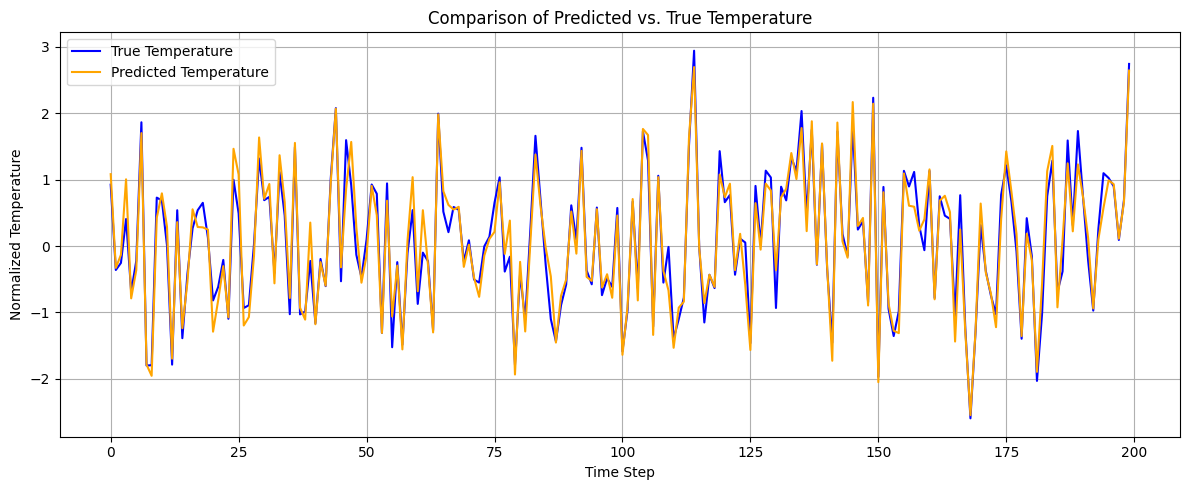

In [36]:
preds_flat = preds.flatten()
targets_flat = targets.flatten()

# Plot first 200 samples for clarity
plt.figure(figsize=(12, 5))
plt.plot(targets_flat[:200], label='True Temperature', color='blue')
plt.plot(preds_flat[:200], label='Predicted Temperature', color='orange')
plt.xlabel('Time Step')
plt.ylabel('Normalized Temperature')
plt.title('Comparison of Predicted vs. True Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### A LSTM Network on Jena Climate Data

Let us now implement a **PyTorch LSTM model** on the same **Jena Climate dataset** used previously for the RNN example. We'll reuse the preprocessed sequences, train a new LSTM-based regressor, and finish with a visualization comparing predictions to true temperature values.

In [37]:
class ClimateLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(ClimateLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # LSTM returns (output_seq, (h_n, c_n)), we use the last hidden state
        out, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])

In [38]:
lstm_model = ClimateLSTM(input_dim=3, hidden_dim=64, num_layers=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

In [39]:
epochs = 50
for epoch in range(epochs):
    lstm_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = lstm_model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

Epoch 0, Loss: 48.7008
Epoch 5, Loss: 10.7107
Epoch 10, Loss: 9.8551
Epoch 15, Loss: 9.3828
Epoch 20, Loss: 9.0803
Epoch 25, Loss: 8.8093
Epoch 30, Loss: 8.5961
Epoch 35, Loss: 8.4624
Epoch 40, Loss: 8.2498
Epoch 45, Loss: 8.1685


In [40]:
# Evaluation
lstm_model.eval()
preds, targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        out = lstm_model(xb)
        preds.append(out.numpy())
        targets.append(yb.numpy())

preds = np.vstack(preds)
targets = np.vstack(targets)
mse = mean_squared_error(targets, preds)
print(f"Test MSE: {mse:.4f}")

Test MSE: 0.0583


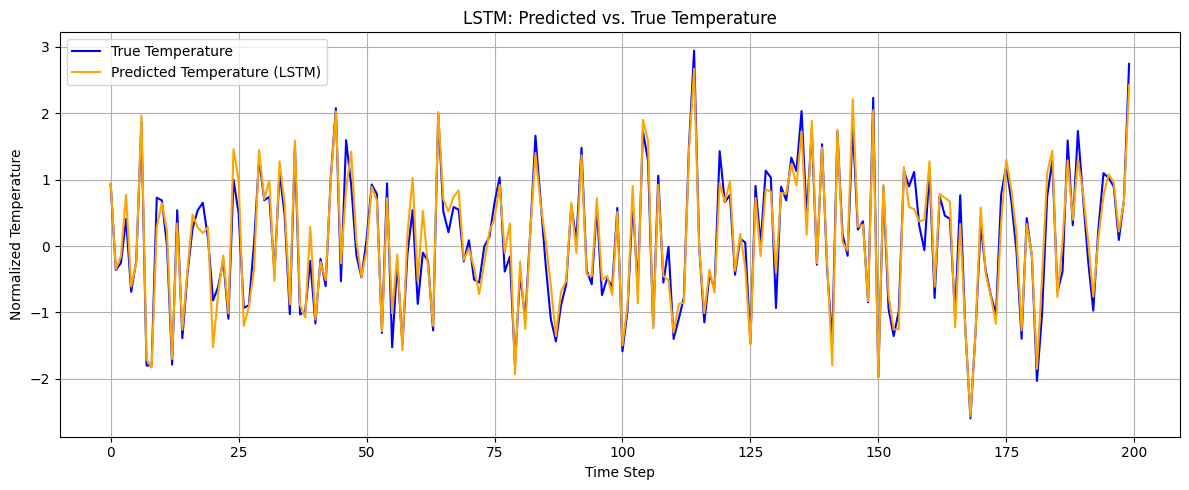

In [41]:
preds_flat = preds.flatten()
targets_flat = targets.flatten()

plt.figure(figsize=(12, 5))
plt.plot(targets_flat[:200], label='True Temperature', color='blue')
plt.plot(preds_flat[:200], label='Predicted Temperature (LSTM)', color='orange')
plt.xlabel('Time Step')
plt.ylabel('Normalized Temperature')
plt.title('LSTM: Predicted vs. True Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Autoencoders

We now turn our attention to **autoencoders**, a class of neural network models designed for **unsupervised representation learning**. An autoencoder learns to encode data into a lower-dimensional latent space and then decode it back to reconstruct the original input. The motivation is to extract informative structure by compressing and reconstructing the input with minimal loss.

We begin by developing the mathematical formalism for **ordinary autoencoders**, then extend the framework to **denoising autoencoders**, and finally to **variational autoencoders**, which incorporate probabilistic modeling.

## Ordinary Autoencoders (AEs)

Let $x \in \mathbb{R}^d$ be an input vector. An autoencoder consists of two parameterized functions:

* An **encoder** $f_\theta: \mathbb{R}^d \to \mathbb{R}^k$,
* A **decoder** $g_\phi: \mathbb{R}^k \to \mathbb{R}^d$,

where $k < d$ in typical settings. These functions are often realized as neural networks.

The autoencoder aims to minimize the **reconstruction error** between input $x$ and its reconstruction $\hat{x} = g_\phi(f_\theta(x))$. The most common loss function is the mean squared error:

$$
\mathcal{L}_{\text{AE}}(\theta, \phi) = \frac{1}{N} \sum_{i=1}^N \left\| x_i - g_\phi(f_\theta(x_i)) \right\|^2.
$$

This minimization induces a mapping to a **low-dimensional manifold** in $\mathbb{R}^k$ that captures the structure of the input distribution. If the encoder and decoder are linear and the loss is MSE, the optimal solution coincides with **principal component analysis (PCA)**.

However, when nonlinearity is introduced (e.g., ReLU, sigmoid), autoencoders can discover nonlinear manifolds and are no longer equivalent to PCA.

## Denoising Autoencoders (DAEs)

To improve robustness and generalization, **denoising autoencoders** were introduced (Vincent et al., 2008). Rather than learning the identity map, the network is trained to recover the clean input from a **corrupted** version.

Let $\tilde{x} \sim q(\tilde{x} \mid x)$ denote a corrupted version of $x$. The DAE is trained to minimize:

$$
\mathcal{L}_{\text{DAE}}(\theta, \phi) = \frac{1}{N} \sum_{i=1}^N \left\| x_i - g_\phi(f_\theta(\tilde{x}_i)) \right\|^2,
$$

where $\tilde{x}_i$ is typically generated by additive Gaussian noise, masking, or dropout.

The DAE learns a **vector field** that points toward regions of high data density. This is related to the **score function** $\nabla \log p(x)$ and establishes connections to energy-based models and diffusion processes.

## Variational Autoencoders (VAEs)

The **variational autoencoder** is a probabilistic generative model introduced by Kingma and Welling (2013). Rather than learning a deterministic latent code, the encoder outputs a distribution over latent variables.

The generative model is defined as:

* Latent prior: $z \sim p(z) = \mathcal{N}(0, I)$,
* Decoder: $x \sim p_\theta(x \mid z)$.

We introduce a variational approximation $q_\phi(z \mid x)$ to the true posterior $p(z \mid x)$ using a neural network encoder that outputs a mean and variance.

The objective is to **maximize the evidence lower bound (ELBO)**:

$$
\log p_\theta(x) \geq \mathbb{E}_{z \sim q_\phi(z \mid x)}[\log p_\theta(x \mid z)] - D_{\text{KL}}(q_\phi(z \mid x) \parallel p(z)),
$$

which trades off:

* A **reconstruction term** encouraging accurate decoding,
* A **regularization term** (KL divergence) that keeps $q_\phi(z \mid x)$ close to the prior.

The encoder outputs parameters $(\mu_\phi(x), \sigma^2_\phi(x))$ of a diagonal Gaussian:

$$
q_\phi(z \mid x) = \mathcal{N}(z; \mu_\phi(x), \text{diag}(\sigma^2_\phi(x))),
$$

and samples $z$ using the **reparameterization trick**:

$$
z = \mu_\phi(x) + \sigma_\phi(x) \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I).
$$

This formulation makes backpropagation feasible despite stochastic sampling.


## A Computational Example: Autoencoder on Olivetti Faces

We now implement a **basic autoencoder** on the **Olivetti Faces** dataset using PyTorch. The dataset consists of $64 \times 64$ grayscale images of faces, which we compress and reconstruct.

Let us first load the dataset:

In [42]:
faces = fetch_olivetti_faces(data_home='/home/kaygun/local/data/')
X = faces.images  # shape (400, 64, 64)

# Flatten images to vectors
X = X.reshape(-1, 64*64)

# Train/test split
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

train_ds = TensorDataset(X_train_tensor)
test_ds = TensorDataset(X_test_tensor)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

In [43]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=4096, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [56]:
autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.999)

In [60]:
for epoch in range(100):
    autoencoder.train()
    total_loss = 0
    for xb, in train_loader:
        optimizer.zero_grad()
        recon = autoencoder(xb)
        loss = criterion(recon, xb)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

Epoch 0, Loss: 0.0473
Epoch 10, Loss: 0.0441
Epoch 20, Loss: 0.0421
Epoch 30, Loss: 0.0402
Epoch 40, Loss: 0.0385
Epoch 50, Loss: 0.0372
Epoch 60, Loss: 0.0359
Epoch 70, Loss: 0.0349
Epoch 80, Loss: 0.0337
Epoch 90, Loss: 0.0330


In [61]:
autoencoder.eval()
with torch.no_grad():
    original = X_test_tensor[:10]
    recon = autoencoder(original)

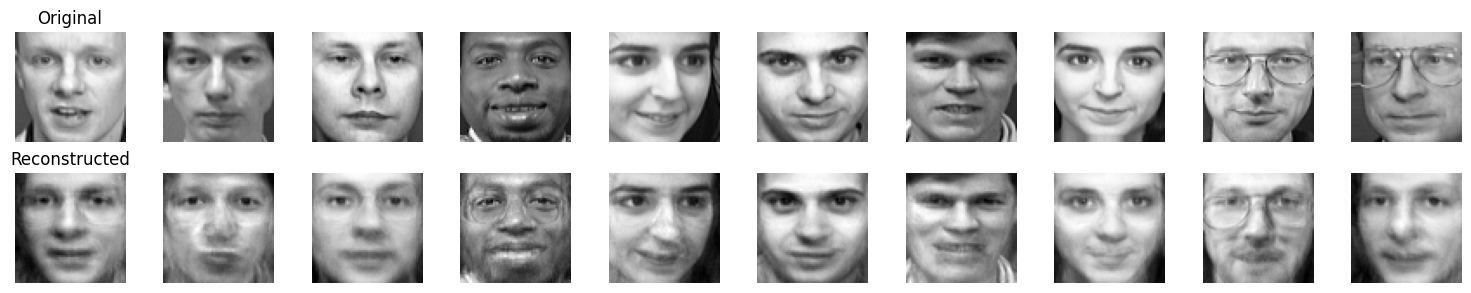

In [62]:
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    axes[0, i].imshow(original[i].view(64, 64), cmap='gray')
    axes[1, i].imshow(recon[i].view(64, 64), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].axis('off')
axes[0, 0].set_title('Original')
axes[1, 0].set_title('Reconstructed')
plt.tight_layout()
plt.show()

## Denoising Autoencoder

We now implement a Denoising Autoencoder (DAE), an extension of the standard autoencoder in which the model is trained to reconstruct the original clean input from a noisy corrupted version. This setup promotes robustness and forces the encoder to learn a latent representation that captures the underlying structure rather than merely memorizing the input.

We proceed with the Olivetti faces dataset from before and introduce additive Gaussian noise during training.

In [63]:
def add_noise(x, noise_factor=0.3):
    noise = noise_factor * torch.randn_like(x)
    x_noisy = x + noise
    return torch.clip(x_noisy, 0., 1.)

In [64]:
autoencoder = Autoencoder()
criterion = nn.L1Loss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)

In [65]:
for epoch in range(100):
    autoencoder.train()
    total_loss = 0
    for xb, in train_loader:
        xb_noisy = add_noise(xb, noise_factor=0.25)
        optimizer.zero_grad()
        recon = autoencoder(xb_noisy)
        loss = criterion(recon, xb)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

Epoch 0, Loss: 1.4303
Epoch 10, Loss: 0.9416
Epoch 20, Loss: 0.8101
Epoch 30, Loss: 0.7582
Epoch 40, Loss: 0.7477
Epoch 50, Loss: 0.7085
Epoch 60, Loss: 0.6676
Epoch 70, Loss: 0.6393
Epoch 80, Loss: 0.6908
Epoch 90, Loss: 0.6123


In [66]:
autoencoder.eval()
with torch.no_grad():
    clean = X_test_tensor[:10]
    noisy = add_noise(clean, noise_factor=0.25)
    recon = autoencoder(noisy)

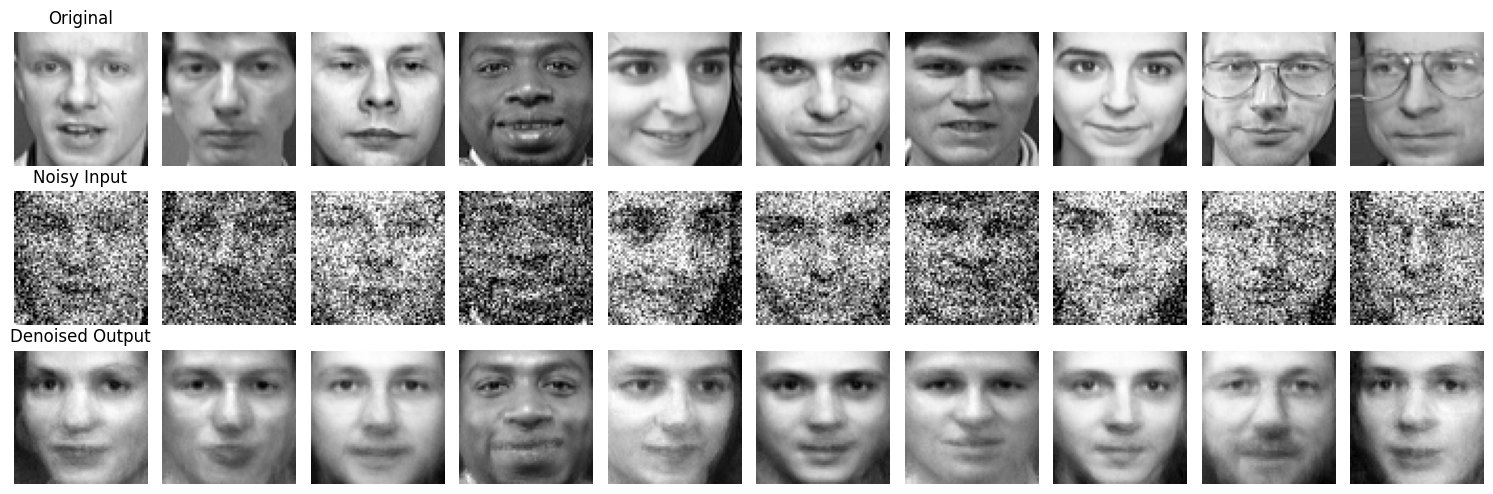

In [67]:
# Plot original, noisy, and reconstructed images
fig, axes = plt.subplots(3, 10, figsize=(15, 5))
for i in range(10):
    axes[0, i].imshow(clean[i].view(64, 64), cmap='gray')
    axes[1, i].imshow(noisy[i].view(64, 64), cmap='gray')
    axes[2, i].imshow(recon[i].view(64, 64), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].axis('off')
    axes[2, i].axis('off')
axes[0, 0].set_title('Original')
axes[1, 0].set_title('Noisy Input')
axes[2, 0].set_title('Denoised Output')
plt.tight_layout()
plt.show()

## Variational Autoencoders

We now implement a **Variational Autoencoder (VAE)**, which extends autoencoders by placing a **probabilistic model** on the latent space. Unlike ordinary or denoising autoencoders, which produce a deterministic latent code, VAEs learn to generate parameters of a probability distribution over latent variables and are trained by maximizing a **variational lower bound (ELBO)** on the data log-likelihood.


### Mathematical Background

Let $x \in \mathbb{R}^d$ be an observed variable and $z \in \mathbb{R}^k$ a latent variable. We define:

* Prior: $p(z) = \mathcal{N}(0, I)$,
* Generative model (decoder): $p_\theta(x \mid z)$,
* Inference model (encoder): $q_\phi(z \mid x) = \mathcal{N}(\mu_\phi(x), \operatorname{diag}(\sigma^2_\phi(x)))$.

We train by maximizing the **evidence lower bound**:

$$
\log p_\theta(x) \geq \mathbb{E}_{z \sim q_\phi(z \mid x)}[\log p_\theta(x \mid z)] - D_{\text{KL}}(q_\phi(z \mid x) \parallel p(z)),
$$

where the first term is a **reconstruction log-likelihood**, and the second is the **KL divergence** between the approximate posterior and the prior.

The sampling is made differentiable via the **reparameterization trick**:

$$
z = \mu_\phi(x) + \sigma_\phi(x) \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I).
$$

### VAE Implementation in PyTorch (on Olivetti Faces)

In [68]:
# Reshape: (400, 64*64) → (400, 1, 64, 64)
X_train_tensor_2d = X_train_tensor.view(-1, 1, 64, 64)
X_test_tensor_2d = X_test_tensor.view(-1, 1, 64, 64)

train_loader_2d = DataLoader(TensorDataset(X_train_tensor_2d), batch_size=32, shuffle=True)
test_loader_2d = DataLoader(TensorDataset(X_test_tensor_2d), batch_size=32)

In [69]:
class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 4, stride=2, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2),                          
            nn.Conv2d(16, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)                           
        )

        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(32 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(32 * 4 * 4, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 32 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),  # (B,16,8,8)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1),   # (B,8,16,16)
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 4, stride=4, padding=0),    # (B,1,64,64)
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        h = self.flatten(h)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(-1, 32, 4, 4)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


In [70]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl

In [71]:
vae = VAE(latent_dim=128)
optimizer = optim.Adam(vae.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999999)

In [80]:
for epoch in range(1000):
    vae.train()
    total_loss = 0
    for xb, in train_loader_2d:
        optimizer.zero_grad()
        x_recon, mu, logvar = vae(xb)
        loss = vae_loss(x_recon, xb, mu, logvar)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.2f}")

Epoch 0, Loss: 841240.55
Epoch 100, Loss: 840892.26
Epoch 200, Loss: 840954.84
Epoch 300, Loss: 840858.05
Epoch 400, Loss: 840851.64
Epoch 500, Loss: 840836.09
Epoch 600, Loss: 840668.73
Epoch 700, Loss: 840652.89
Epoch 800, Loss: 840669.23
Epoch 900, Loss: 840731.62


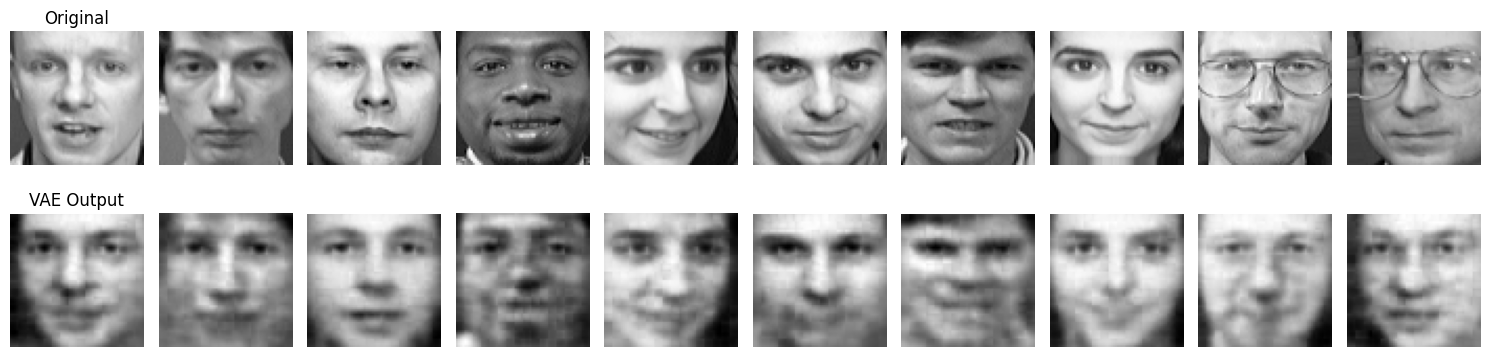

In [81]:
vae.eval()
with torch.no_grad():
    sample = X_test_tensor_2d[:10]
    recon, _, _ = vae(sample)

fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    axes[0, i].imshow(sample[i][0].cpu(), cmap='gray')
    axes[1, i].imshow(recon[i][0].cpu(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].axis('off')
    
axes[0, 0].set_title("Original")
axes[1, 0].set_title("VAE Output")
plt.tight_layout()
plt.show()

## Using variational autoencoders to generate new outputs

### Mathematical Foundation

Recall that the encoder $q_\phi(z \mid x)$ has been trained to approximate samples from the standard normal prior
$$
p(z) = \mathcal{N}(0, I_p),
$$
where $p$ is the dimension of the latent space (in our case $p=20$). Thus, after training, we can **sample latent vectors** directly from the prior $p(z)$, namely by generating
$$
z \sim \mathcal{N}(0, I_p),
$$
and then **decode** these latent samples via the decoder network $g_\theta$ to produce new synthetic images
$$
\hat{x} = g_\theta(z).
$$

This procedure provides a method of **generative sampling**, exploiting the VAE’s probabilistic structure.  Let us implement this explicitly.

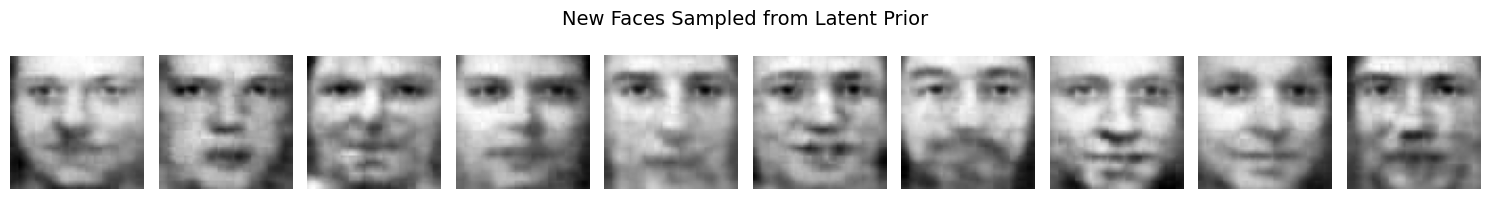

In [83]:
vae.eval()
with torch.no_grad():
    # Sample from the standard normal prior
    z_samples = torch.randn(10, 128)  # 10 latent vectors of dimension 64
    generated = vae.decode(z_samples)  # Decode to image space


fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(generated[i][0].cpu(), cmap='gray')
    axes[i].axis('off')
plt.suptitle("New Faces Sampled from Latent Prior", fontsize=14)
plt.tight_layout()
plt.show()

### Formal Observations:

- The sampling process does **not** require any actual training data. It proceeds entirely by exploiting the learned decoder $g_\theta$ and the assumed prior distribution on latent variables.
- The quality of the generated samples depends critically on how well $q_\phi(z \mid x)$ has been regularized toward $p(z)$.  
If the KL divergence term during training was effective, samples $z \sim \mathcal{N}(0,I_p)$ will map to plausible faces.
- In cases where the VAE is undertrained, or the prior is not well matched to the empirical posterior, generated faces may appear blurry, noisy, or unnatural. This reflects the inherent difficulty of capturing complex high-dimensional data distributions with simple isotropic Gaussian priors.

